In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

from IPython.display import clear_output

from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix

from ripser import ripser
from persim import plot_diagrams

In [2]:
df = pd.read_csv('./data/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
model = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination='auto',
    max_features=1.0,
    bootstrap=False
).fit(df.drop('Class', axis=1))

In [6]:
preds = model.predict(df.drop('Class', axis=1))

In [7]:
y_pred = (-1*preds + 1)/2

In [8]:
y_true = df['Class'].values

In [9]:
M = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize='true') # For TPR, FPR, TNR, FNR

In [10]:
print(
    "trueNegativeRate = %2.2f\n" % (M[0, 0] * 100),
    "falseNegativeRate = %2.2f\n" % (M[1, 0] * 100),
    "truePositiveRate = %2.2f\n" % (M[1, 1] * 100),
    "falsePositiveRate = %2.2f" % (M[0, 1] * 100)
)

trueNegativeRate = 96.10
 falseNegativeRate = 16.46
 truePositiveRate = 83.54
 falsePositiveRate = 3.90


In [11]:
anomalyScores = model.score_samples(df.drop('Class', axis=1))

In [12]:
def computeTreeScores(df, model):
    arr = np.zeros((df.shape[0], model.n_estimators))
    
    for i, tree in enumerate(model.estimators_):
        arr[:, i] = tree.predict(df.drop('Class', axis=1))
        
    return arr

In [22]:
downsampleDf = df.sample(1000)

In [23]:
treeScores = computeTreeScores(downsampleDf, model)

In [24]:
treeScores.shape

(1000, 100)

In [35]:
def computeHammingDistance(treeScores, i, j):
    return (treeScores[i, :] != treeScores[j, :]).astype(int).sum()

In [36]:
def computeHammingDistanceMatrix(treeScores):
    numSamples = treeScores.shape[0]
    
    distMat = np.zeros((numSamples, numSamples))
    for i in range(numSamples):
        for j in range(0, i):
            distMat[i, j] = computeHammingDistance(treeScores, i, j)
        clear_output(wait = True)
        print('Progress: %2.2f%%' % (50 * (i+1) / numSamples))
        
    for i in range(numSamples):
        for j in range(i+1, numSamples):
            distMat[i, j] = distMat[j, i]
        clear_output(wait=True)
        print('Progress: %2.2f%%' % (50 + (50 * (i+1) / numSamples)))
            
    return distMat

In [37]:
distMat = computeHammingDistanceMatrix(treeScores)

Progress: 100.00%


In [43]:
pHom = ripser(
    distMat,
    maxdim=2,
    coeff=2, # This is actually the default lol, We need to RTFM
    distance_matrix=True
)

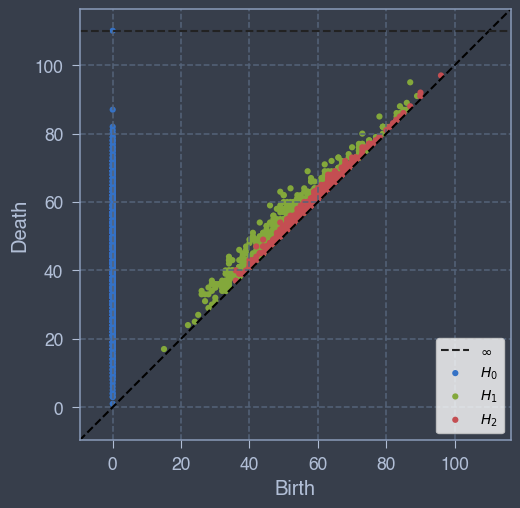

In [50]:
plot_diagrams(pHom['dgms'])
jtplot.style(ticks=True, grid=True, gridlines='--')  # Ugh